In [3]:
import tensorflow as tf
print("Versão do TensorFlow:", tf.__version__)

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model

Versão do TensorFlow: 2.16.1


In [4]:
def create_model(conv_layers=2, conv_filters=32, filter_size=(3, 3), 
                 dense_units=128, dropout_rate=0.5, input_shape=(64, 64, 3), 
                 activation='relu', output_activation='sigmoid', optimizer='adam', 
                 loss='binary_crossentropy', metrics=['accuracy']):
    # Inicializando a Rede Neural Convolucional
    model = Sequential()

    # Primeira camada de Convolução
    model.add(Conv2D(conv_filters, filter_size, input_shape=input_shape, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Camadas adicionais de Convolução
    for _ in range(conv_layers - 1):
        model.add(Conv2D(conv_filters, filter_size, activation=activation))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten
    model.add(Flatten())

    # Full connection
    model.add(Dense(units=dense_units, activation=activation))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=1, activation=output_activation))

    # Compilando a rede
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [5]:
def train_model(model, train_dir, test_dir, img_height=64, img_width=64, batch_size=32, epochs=5):
    # Data augmentation e normalização
    train_image_generator = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    validation_image_generator = ImageDataGenerator(rescale=1./255)

    # Geradores de dados
    train_data_gen = train_image_generator.flow_from_directory(
        batch_size=batch_size,
        directory=train_dir,
        shuffle=True,
        target_size=(img_height, img_width),
        class_mode='binary'
    )

    val_data_gen = validation_image_generator.flow_from_directory(
        batch_size=batch_size,
        directory=test_dir,
        target_size=(img_height, img_width),
        class_mode='binary'
    )

    # Calculando steps_per_epoch e validation_steps
    steps_per_epoch = train_data_gen.samples // batch_size
    validation_steps = val_data_gen.samples // batch_size

    # Treinamento
    history = model.fit(
        train_data_gen, 
        steps_per_epoch=steps_per_epoch,
        epochs=epochs, 
        validation_data=val_data_gen, 
        validation_steps=validation_steps
    )
    
    return history

In [6]:
def train_and_evaluate(hyperparameters, train_dir, test_dir, img_height=64, img_width=64, batch_size=32, epochs=5):
    results = []
    for idx, params in enumerate(hyperparameters):
        print(f"Training model {idx + 1} with hyperparameters: {params}")
        model = create_model(
            conv_layers=params['conv_layers'],
            conv_filters=params['conv_filters'],
            filter_size=params['filter_size'],
            dense_units=params['dense_units'],
            dropout_rate=params['dropout_rate']
        )
        history = train_model(
            model, 
            train_dir, 
            test_dir, 
            img_height=img_height, 
            img_width=img_width, 
            batch_size=batch_size, 
            epochs=epochs
        )
        results.append(history.history)
    return results

In [7]:
def plot_results(results, epochs):
    plt.figure(figsize=(20, 10))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for idx, history in enumerate(results):
        plt.plot(range(1, epochs + 1), history['accuracy'], label=f'Model {idx + 1} Train')
        plt.plot(range(1, epochs + 1), history['val_accuracy'], '--', label=f'Model {idx + 1} Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for idx, history in enumerate(results):
        plt.plot(range(1, epochs + 1), history['loss'], label=f'Model {idx + 1} Train')
        plt.plot(range(1, epochs + 1), history['val_loss'], '--', label=f'Model {idx + 1} Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


Training model 1 with hyperparameters: {'conv_layers': 2, 'conv_filters': 32, 'filter_size': (3, 3), 'dense_units': 128, 'dropout_rate': 0.5}
Found 196 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.5965 - loss: 0.6871 - val_accuracy: 0.4219 - val_loss: 0.6912
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5312 - loss: 0.6928 - val_accuracy: 0.4444 - val_loss: 0.7413
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5464 - loss: 0.7277 - val_accuracy: 0.5781 - val_loss: 0.6286
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6250 - loss: 0.6255 - val_accuracy: 0.5556 - val_loss: 0.6420
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5547 - loss: 0.6695 - val_accuracy: 0.6250 - val_loss: 0.5535
Training model 2 with hyperparameters: {'conv_layers': 3, 'conv_filters': 64, 'filter_size': (3, 3), 'dense_units': 256, 'dropout_rate': 0.5}
Found 196 images 

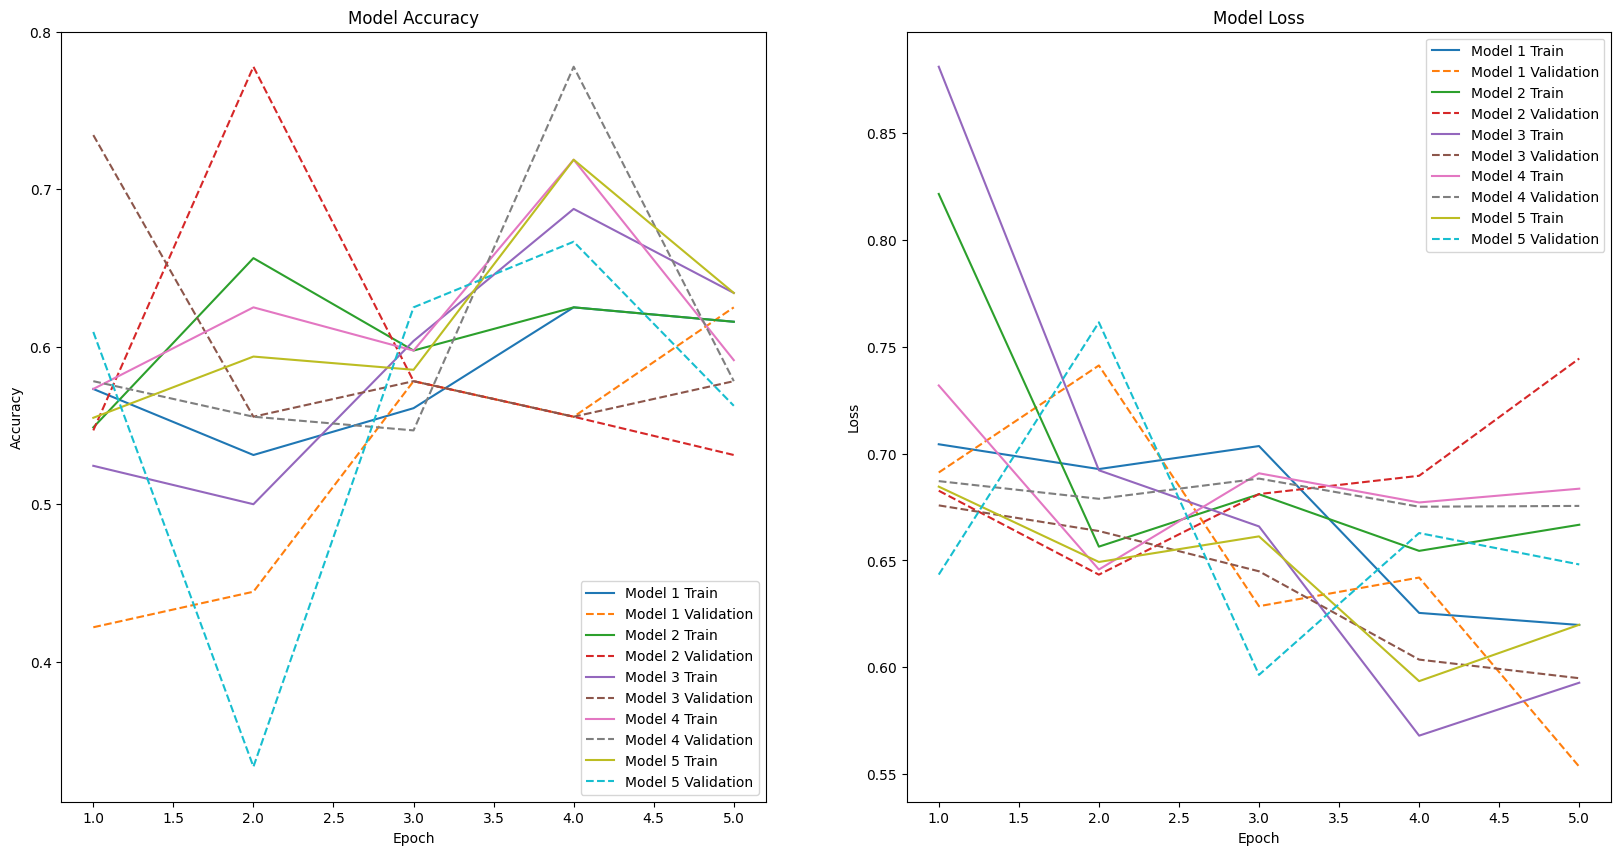

In [8]:
# Definir diretórios das imagens
base_dir = 'dataset_personagens'
train_dir = os.path.join(base_dir, 'training_set')
test_dir = os.path.join(base_dir, 'test_set')

# Definir variáveis para as dimensões das imagens, tamanho do lote e épocas
img_height = 64
img_width = 64
batch_size = 32
epochs = 5

# Hiperparâmetros
hyperparameter_combinations = [
    {'conv_layers': 2, 'conv_filters': 32, 'filter_size': (3, 3), 'dense_units': 128, 'dropout_rate': 0.5},
    {'conv_layers': 3, 'conv_filters': 64, 'filter_size': (3, 3), 'dense_units': 256, 'dropout_rate': 0.5},
    {'conv_layers': 2, 'conv_filters': 32, 'filter_size': (5, 5), 'dense_units': 128, 'dropout_rate': 0.3},
    {'conv_layers': 4, 'conv_filters': 64, 'filter_size': (3, 3), 'dense_units': 512, 'dropout_rate': 0.5},
    {'conv_layers': 3, 'conv_filters': 32, 'filter_size': (3, 3), 'dense_units': 128, 'dropout_rate': 0.2}
]

# Treinando e coletando os resultados
results = train_and_evaluate(hyperparameter_combinations, train_dir, test_dir, img_height, img_width, batch_size, epochs)

# Plotando os resultados
plot_results(results, epochs)
  